Columns in final_df: ['new_minute_index', 'carparkName', 'availableEvChargingSpace', 'totalEvChargingSpace', 'Collected timestamp', 'usage', 'date']
   new_minute_index carparkName  availableEvChargingSpace  \
0                 0          P2                       6.0   
1                 1          P2                       6.0   
2                 2          P2                       6.0   
3                 3          P2                       6.0   
4                 4          P2                       6.0   

   totalEvChargingSpace Collected timestamp     usage        date  
0                  29.0 2024-11-13 00:38:47  0.793103  2024-11-13  
1                  29.0 2024-11-13 00:38:47  0.793103  2024-11-13  
2                  29.0 2024-11-13 00:38:47  0.793103  2024-11-13  
3                  29.0 2024-11-13 00:38:47  0.793103  2024-11-13  
4                  29.0 2024-11-13 00:38:47  0.793103  2024-11-13  


/var/folders/sj/2p6wz56s1ydg4dt60j2x0ppw0000gn/T/ipykernel_26312/2856208364.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")


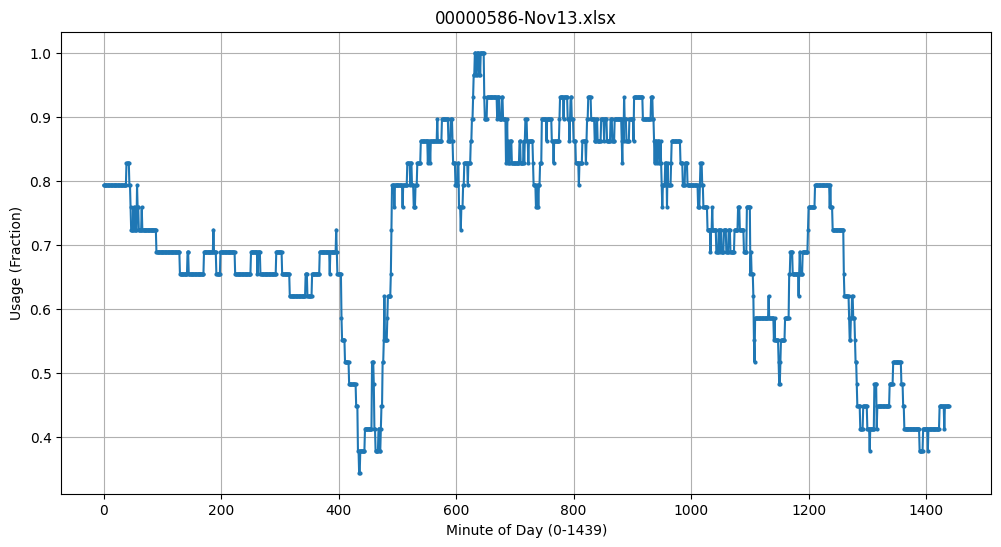

In [3]:
import pandas as pd
import glob
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Specify the directory and file pattern for your XLSX files.
file_pattern = "00000586-Nov13.xlsx"  # Replace with your folder path
files = glob.glob(file_pattern)

# List to hold the cleaned DataFrames (one per day/file)
cleaned_days = []

for file in files:
    try:
        # Read the Excel file using the openpyxl engine.
        df = pd.read_excel(file, engine='openpyxl')
    except Exception as e:
        print(f"Error reading {file}: {e}")
        continue

    # 1. Keep only the required columns.
    required_cols = [
        "carparkName", 
        "availableEvChargingSpace", 
        "totalEvChargingSpace", 
        "Collected timestamp"
    ]
    df = df[required_cols]

    # 2. Filter rows for carparkName 'P2'
    df = df[df["carparkName"] == "P2"]

    # 3. Convert "Collected timestamp" to datetime.
    df["Collected timestamp"] = pd.to_datetime(df["Collected timestamp"])

    # Determine the day of the data (we assume one file per day)
    unique_dates = df["Collected timestamp"].dt.date.unique()
    if len(unique_dates) != 1:
        print(f"Warning: {file} contains data for multiple days. Using the first date encountered.")
    day_date = unique_dates[0]
    
    # Define day's start and the expected day’s end (midnight of the next day)
    day_start = pd.Timestamp(datetime.combine(day_date, datetime.min.time()))
    day_end = day_start + pd.Timedelta(days=1)  # This is 24:00 or 00:00 of the next day

    # 4. Identify the anchor row (the record closest to day_end)
    df["delta"] = (day_end - df["Collected timestamp"]).abs()
    anchor_idx = df["delta"].idxmin()
    T_anchor = df.loc[anchor_idx, "Collected timestamp"]

    # 5. Create a new minute index.
    # We want the row at T_anchor to be at minute index 1439.
    df["new_minute_index"] = 1439 - (
        (T_anchor - df["Collected timestamp"]).dt.total_seconds() / 60
    ).astype(int)
    
    # 6. Sort the DataFrame by new_minute_index and reindex so that every minute (0 to 1439) is present.
    df = df.set_index("new_minute_index").sort_index()
    complete_index = range(1440)  # 0 to 1439
    df = df.reindex(complete_index)
    # Fill missing rows by first forward filling then backward filling if necessary.
    df = df.fillna(method="ffill").fillna(method="bfill")
    
    # 7. Compute the usage metric as a fraction.
    # usage = (totalEvChargingSpace - availableEvChargingSpace) / totalEvChargingSpace
    df["usage"] = (df["totalEvChargingSpace"] - df["availableEvChargingSpace"]) / df["totalEvChargingSpace"]

    # 8. Record the actual date for later reference.
    df["date"] = day_date

    # Drop the temporary column ("delta")
    df = df.drop(columns=["delta"], errors='ignore')
    
    # Append cleaned dataframe for this day to our list
    cleaned_days.append(df)

# Combine the data from all days into one DataFrame.
# Since each day’s DataFrame uses the minute index (0 to 1439), we use ignore_index=False.
final_df = pd.concat(cleaned_days, ignore_index=False)

# Reset the index so that our index becomes a column.
# The old index gets moved into a column named "index". We then rename it to "minute_index".
final_df = final_df.reset_index().rename(columns={"index": "minute_index"})

# DEBUG: Print the columns to verify that "minute_index" is present.
print("Columns in final_df:", final_df.columns.tolist())
print(final_df.head())

# --- Plotting ---
plt.figure(figsize=(12, 6))
plt.plot(final_df["new_minute_index"], final_df["usage"], marker="o", markersize=2)
plt.xlabel("Minute of Day (0-1439)")
plt.ylabel("Usage (Fraction)")
plt.title(file_pattern)
plt.grid(True)
plt.show()

In [16]:
final_df.iloc[6000]

new_minute_index                            240
carparkName                                  P2
availableEvChargingSpace                   11.0
totalEvChargingSpace                       29.0
Collected timestamp         2024-11-26 03:59:46
usage                                   0.62069
date                                 2024-11-26
Name: 6000, dtype: object